In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [2]:
data = pd.read_csv('C:/bhawit_SOE/data_1.csv')

In [3]:
data

,Time,Potential,Current,Energy
0,0.4,3.97,0.400,6.543850
1,1.0,3.97,1.250,6.539924
2,2.0,3.98,1.250,6.557691
3,3.0,3.98,1.250,6.559173
4,4.0,3.98,1.250,6.560477
...,...,...,...,...
1048567,1048567.0,4.20,0.828,9.800000
1048568,1048568.0,4.20,0.827,9.800000
1048569,1048569.0,4.20,0.826,9.800000
1048570,1048570.0,4.20,0.826,9.800000


In [4]:
data.describe()

,Time,Potential,Current,Energy
count,1.048572e+06,1.048572e+06,1.048572e+06,1.048572e+06
mean,5.242855e+05,3.814223e+00,1.833261e-03,5.996555e+00
std,3.026968e+05,3.940242e-01,1.285114e+00,3.943820e+00
min,4.000000e-01,2.750000e+00,-2.500000e+00,0.000000e+00
25%,2.621428e+05,3.400000e+00,0.000000e+00,2.038056e+00
50%,5.242855e+05,3.890000e+00,7.400000e-02,6.408889e+00
75%,7.864282e+05,4.190000e+00,1.250000e+00,1.010333e+01
max,1.048571e+06,4.200000e+00,1.270000e+00,1.099000e+01


In [5]:
data.isnull().sum()

Time         0
Potential    0
Current      0
Energy       0
dtype: int64

# Data Modeling

In [6]:
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

numericals = ['Time','Potential','Current'] # Not Normalizing the Y(target Variable) - which is SOC
data[numericals] = scaler.fit_transform(data[numericals])

In [7]:
data.head()


,Time,Potential,Current,Energy
0,0.000000e+00,0.841379,0.769231,6.543850
1,5.722075e-07,0.841379,0.994695,6.539924
2,1.525887e-06,0.848276,0.994695,6.557691
3,2.479566e-06,0.848276,0.994695,6.559173
4,3.433245e-06,0.848276,0.994695,6.560477


In [8]:
Y = data.pop('Energy')
X = data

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.2)

In [10]:
X_train.shape , X_test.shape , Y_train.shape , Y_test.shape

((838857, 3), (209715, 3), (838857,), (209715,))

In [11]:
X_train.head()

,Time,Potential,Current
162596,0.155064,0.524138,0.000000
1016218,0.969146,0.993103,0.663130
301414,0.287452,0.586207,0.994695
313953,0.299410,0.993103,0.663130
796902,0.759989,0.682759,0.994695


In [12]:
def plot_his(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

In [13]:
from tensorflow.keras.callbacks import EarlyStopping
callback = EarlyStopping(
    monitor = 'val_loss' ,
    min_delta = 0.00001,
    patience = 15,
    verbose = 1,
    mode = 'auto',
    baseline = None,
    restore_best_weights = False
)

# AIC

In [14]:
import tensorflow as tf
from scipy.stats import norm

# Train your model using TensorFlow
def AIC_value(model,Y_pred,Y_test):

    Y_test = np.asarray(Y_test).astype('float32').reshape((-1,1))
    Y_pred_1 = np.asarray(Y_pred).astype('float32').reshape((-1,1))


    # Calculate the negative log-likelihood of the model's parameters based on the training data
    nll = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=Y_test, logits=Y_pred_1))

    # Calculate the number of parameters in the model
    num_params = model.count_params()

    # Calculate the AIC value for the model
    aic = 2 * num_params - 2 * nll

    # Print the AIC value
    print("AIC: ", aic.numpy())

In [15]:
# pip install tensorflow_addons

In [16]:
import tensorflow_addons as tfa

C:\Users\91987\anaconda3\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [17]:
%%time
import tensorflow as tf

tf.random.set_seed(42)

model_1 = tf.keras.Sequential([tf.keras.layers.Dense(50,activation = 'relu'),
                               tf.keras.layers.Dropout(0.2),
                               tf.keras.layers.Dense(100 ,activation = 'relu'),
                               tf.keras.layers.Dropout(0.2),
                               tf.keras.layers.Dense(100),
                               tf.keras.layers.Dense(50),
                               tf.keras.layers.Dense(10),
                               tf.keras.layers.Dense(1)])

model_1.compile(loss = tf.keras.losses.mae,
                optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001,decay=0.001),
                metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse'),
                         tfa.metrics.RSquare(name='r2'),'mae','mse','mape'])

history_1 = model_1.fit(X_train,Y_train, epochs= 100,batch_size=32,validation_data=(X_test,Y_test), callbacks = callback)

Epoch 1/100
26215/26215 [==============================] - 78s 3ms/step - loss: 0.3857 - rmse: 0.5555 - r2: 0.9802 - mae: 0.3857 - mse: 0.3086 - mape: 580567.5625 - val_loss: 0.8597 - val_rmse: 1.0608 - val_r2: 0.9276 - val_mae: 0.8597 - val_mse: 1.1254 - val_mape: 385405.7500
Epoch 2/100
26215/26215 [==============================] - 54s 2ms/step - loss: 0.3346 - rmse: 0.4502 - r2: 0.9870 - mae: 0.3346 - mse: 0.2026 - mape: 723518.1875 - val_loss: 0.8525 - val_rmse: 1.0582 - val_r2: 0.9280 - val_mae: 0.8525 - val_mse: 1.1199 - val_mape: 389082.3125
Epoch 3/100
26215/26215 [==============================] - 54s 2ms/step - loss: 0.3284 - rmse: 0.4412 - r2: 0.9875 - mae: 0.3284 - mse: 0.1947 - mape: 762381.7500 - val_loss: 0.8162 - val_rmse: 1.0192 - val_r2: 0.9332 - val_mae: 0.8162 - val_mse: 1.0388 - val_mape: 465445.2812
Epoch 4/100
26215/26215 [==============================] - 52s 2ms/step - loss: 0.3257 - rmse: 0.4376 - r2: 0.9877 - mae: 0.3257 - mse: 0.1915 - mape: 743770.8750 - v

26215/26215 [==============================] - 53s 2ms/step - loss: 0.3114 - rmse: 0.4189 - r2: 0.9887 - mae: 0.3114 - mse: 0.1754 - mape: 800183.1250 - val_loss: 0.7294 - val_rmse: 0.9189 - val_r2: 0.9457 - val_mae: 0.7294 - val_mse: 0.8444 - val_mape: 502958.9688
Epoch 60/100
26215/26215 [==============================] - 53s 2ms/step - loss: 0.3105 - rmse: 0.4177 - r2: 0.9888 - mae: 0.3105 - mse: 0.1745 - mape: 785363.0000 - val_loss: 0.7307 - val_rmse: 0.9210 - val_r2: 0.9454 - val_mae: 0.7307 - val_mse: 0.8483 - val_mape: 498727.3125
Epoch 61/100
26215/26215 [==============================] - 54s 2ms/step - loss: 0.3111 - rmse: 0.4187 - r2: 0.9887 - mae: 0.3111 - mse: 0.1753 - mape: 800664.3125 - val_loss: 0.7263 - val_rmse: 0.9153 - val_r2: 0.9461 - val_mae: 0.7263 - val_mse: 0.8378 - val_mape: 507277.9062
Epoch 62/100
26215/26215 [==============================] - 53s 2ms/step - loss: 0.3108 - rmse: 0.4178 - r2: 0.9888 - mae: 0.3108 - mse: 0.1745 - mape: 799363.6875 - val_loss: 

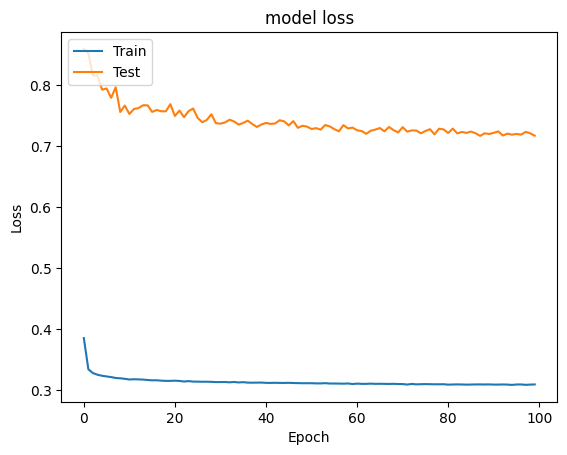

In [18]:
plot_his(history_1)

In [19]:
model_1.evaluate(X_test,Y_test)

6554/6554 [==============================] - 8s 1ms/step - loss: 0.7174 - rmse: 0.9057 - r2: 0.9472 - mae: 0.7174 - mse: 0.8203 - mape: 490517.3125


[0.717424213886261,
 0.9057292342185974,
 0.9472376108169556,
 0.717424213886261,
 0.8203454613685608,
 490517.3125]

In [20]:
Y_pred_1 = model_1.predict(X_test)

6554/6554 [==============================] - 5s 761us/step


In [21]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                200       
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 100)               5100      
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 50)                5050      
                                                                 
 dense_4 (Dense)             (None, 10)                5

In [22]:
AIC_value(model_1,Y_pred_1,Y_test)

AIC:  42021.258


In [23]:
model_1.save('Saved_models/model_1_SOEesti.h5')

In [24]:
%%time
tf.random.set_seed(42)

model_2 = tf.keras.Sequential([tf.keras.layers.Dense(150,activation = 'linear'),
                               tf.keras.layers.Dense(100,activation = 'relu'),
                               tf.keras.layers.Dense(50),
                               tf.keras.layers.Dense(20),
                               tf.keras.layers.Dense(1)])

model_2.compile(loss = tf.keras.losses.mae,
                optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001,decay=0.001),
                metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse'),
                         tfa.metrics.RSquare(name='r2'),'mae','mse','mape'])

history_2 = model_2.fit(X_train,Y_train, epochs= 100,batch_size=32,validation_data=(X_test,Y_test), callbacks = callback)

Epoch 1/100
26215/26215 [==============================] - 46s 2ms/step - loss: 0.0637 - rmse: 0.1961 - r2: 0.9975 - mae: 0.0637 - mse: 0.0385 - mape: 51457.7969 - val_loss: 0.0430 - val_rmse: 0.0731 - val_r2: 0.9997 - val_mae: 0.0430 - val_mse: 0.0053 - val_mape: 32731.5820
Epoch 2/100
26215/26215 [==============================] - 45s 2ms/step - loss: 0.0409 - rmse: 0.0700 - r2: 0.9997 - mae: 0.0409 - mse: 0.0049 - mape: 27529.4609 - val_loss: 0.0385 - val_rmse: 0.0680 - val_r2: 0.9997 - val_mae: 0.0385 - val_mse: 0.0046 - val_mape: 21158.5996
Epoch 3/100
26215/26215 [==============================] - 45s 2ms/step - loss: 0.0381 - rmse: 0.0663 - r2: 0.9997 - mae: 0.0381 - mse: 0.0044 - mape: 20620.0098 - val_loss: 0.0379 - val_rmse: 0.0661 - val_r2: 0.9997 - val_mae: 0.0379 - val_mse: 0.0044 - val_mape: 33089.2031
Epoch 4/100
26215/26215 [==============================] - 45s 2ms/step - loss: 0.0371 - rmse: 0.0650 - r2: 0.9997 - mae: 0.0371 - mse: 0.0042 - mape: 23672.6152 - val_loss

Epoch 31/100
26215/26215 [==============================] - 45s 2ms/step - loss: 0.0338 - rmse: 0.0596 - r2: 0.9998 - mae: 0.0338 - mse: 0.0035 - mape: 19310.4980 - val_loss: 0.0341 - val_rmse: 0.0601 - val_r2: 0.9998 - val_mae: 0.0341 - val_mse: 0.0036 - val_mape: 20246.0488
Epoch 32/100
26215/26215 [==============================] - 44s 2ms/step - loss: 0.0338 - rmse: 0.0595 - r2: 0.9998 - mae: 0.0338 - mse: 0.0035 - mape: 19273.4844 - val_loss: 0.0340 - val_rmse: 0.0601 - val_r2: 0.9998 - val_mae: 0.0340 - val_mse: 0.0036 - val_mape: 18641.5977
Epoch 33/100
26215/26215 [==============================] - 45s 2ms/step - loss: 0.0338 - rmse: 0.0595 - r2: 0.9998 - mae: 0.0338 - mse: 0.0035 - mape: 19401.2500 - val_loss: 0.0342 - val_rmse: 0.0602 - val_r2: 0.9998 - val_mae: 0.0342 - val_mse: 0.0036 - val_mape: 12970.2568
Epoch 34/100
26215/26215 [==============================] - 45s 2ms/step - loss: 0.0338 - rmse: 0.0595 - r2: 0.9998 - mae: 0.0338 - mse: 0.0035 - mape: 19474.7324 - val_

Epoch 61/100
26215/26215 [==============================] - 44s 2ms/step - loss: 0.0335 - rmse: 0.0590 - r2: 0.9998 - mae: 0.0335 - mse: 0.0035 - mape: 21467.4336 - val_loss: 0.0337 - val_rmse: 0.0596 - val_r2: 0.9998 - val_mae: 0.0337 - val_mse: 0.0036 - val_mape: 21845.3633
Epoch 62/100
26215/26215 [==============================] - 45s 2ms/step - loss: 0.0335 - rmse: 0.0590 - r2: 0.9998 - mae: 0.0335 - mse: 0.0035 - mape: 21793.1016 - val_loss: 0.0338 - val_rmse: 0.0596 - val_r2: 0.9998 - val_mae: 0.0338 - val_mse: 0.0036 - val_mape: 19570.8965
Epoch 63/100
26215/26215 [==============================] - 45s 2ms/step - loss: 0.0335 - rmse: 0.0590 - r2: 0.9998 - mae: 0.0335 - mse: 0.0035 - mape: 21591.6895 - val_loss: 0.0337 - val_rmse: 0.0596 - val_r2: 0.9998 - val_mae: 0.0337 - val_mse: 0.0036 - val_mape: 21602.5527
Epoch 64/100
26215/26215 [==============================] - 44s 2ms/step - loss: 0.0335 - rmse: 0.0590 - r2: 0.9998 - mae: 0.0335 - mse: 0.0035 - mape: 21628.9941 - val_

Epoch 91/100
26215/26215 [==============================] - 45s 2ms/step - loss: 0.0334 - rmse: 0.0588 - r2: 0.9998 - mae: 0.0334 - mse: 0.0035 - mape: 21971.0742 - val_loss: 0.0336 - val_rmse: 0.0594 - val_r2: 0.9998 - val_mae: 0.0336 - val_mse: 0.0035 - val_mape: 21076.4141
Epoch 92/100
26215/26215 [==============================] - 45s 2ms/step - loss: 0.0333 - rmse: 0.0588 - r2: 0.9998 - mae: 0.0333 - mse: 0.0035 - mape: 21881.6816 - val_loss: 0.0336 - val_rmse: 0.0594 - val_r2: 0.9998 - val_mae: 0.0336 - val_mse: 0.0035 - val_mape: 20722.1211
Epoch 93/100
26215/26215 [==============================] - 45s 2ms/step - loss: 0.0333 - rmse: 0.0588 - r2: 0.9998 - mae: 0.0333 - mse: 0.0035 - mape: 22008.0195 - val_loss: 0.0336 - val_rmse: 0.0594 - val_r2: 0.9998 - val_mae: 0.0336 - val_mse: 0.0035 - val_mape: 21813.8887
Epoch 94/100
26215/26215 [==============================] - 45s 2ms/step - loss: 0.0333 - rmse: 0.0588 - r2: 0.9998 - mae: 0.0333 - mse: 0.0035 - mape: 22363.5977 - val_

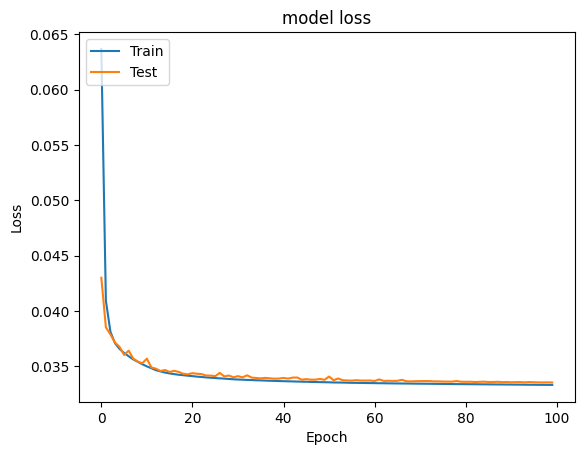

In [25]:
plot_his(history_2)

In [26]:
model_2.evaluate(X_test,Y_test)

6554/6554 [==============================] - 7s 1ms/step - loss: 0.0335 - rmse: 0.0593 - r2: 0.9998 - mae: 0.0335 - mse: 0.0035 - mape: 23035.9883


[0.03353738412261009,
 0.059344276785850525,
 0.9997735023498535,
 0.03353738412261009,
 0.003521743230521679,
 23035.98828125]

In [27]:
Y_pred_2 = model_2.predict(X_test)

6554/6554 [==============================] - 5s 802us/step


In [28]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 150)               600       
                                                                 
 dense_7 (Dense)             (None, 100)               15100     
                                                                 
 dense_8 (Dense)             (None, 50)                5050      
                                                                 
 dense_9 (Dense)             (None, 20)                1020      
                                                                 
 dense_10 (Dense)            (None, 1)                 21        
                                                                 
Total params: 21,791
Trainable params: 21,791
Non-trainable params: 0
_________________________________________________________________


In [29]:
AIC_value(model_2,Y_pred_2,Y_test)

AIC:  43672.68


In [30]:
model_2.save('Saved_models/model_2_SOEesti.h5')

In [17]:
%%time
tf.random.set_seed(42)

model_3 = tf.keras.Sequential([tf.keras.layers.Dense(32,activation = 'relu'),
                               tf.keras.layers.Dense(128,activation = 'relu'),
                               tf.keras.layers.Dense(64),
                               tf.keras.layers.Dense(32),
                               tf.keras.layers.Dense(1)])

model_3.compile(loss = tf.keras.losses.mae,
                optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001,decay=0.001),
                metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse'),
                         tfa.metrics.RSquare(name='r2'),'mae','mse','mape'])

history_3 = model_3.fit(X_train,Y_train, epochs= 100,batch_size=32,validation_data=(X_test,Y_test), callbacks = callback)

Epoch 1/100
26215/26215 [==============================] - 62s 2ms/step - loss: 0.0631 - rmse: 0.2233 - r2: 0.9968 - mae: 0.0631 - mse: 0.0499 - mape: 61493.7734 - val_loss: 0.0411 - val_rmse: 0.0676 - val_r2: 0.9997 - val_mae: 0.0411 - val_mse: 0.0046 - val_mape: 30027.8672
Epoch 2/100
26215/26215 [==============================] - 61s 2ms/step - loss: 0.0392 - rmse: 0.0657 - r2: 0.9997 - mae: 0.0392 - mse: 0.0043 - mape: 23097.1309 - val_loss: 0.0382 - val_rmse: 0.0646 - val_r2: 0.9997 - val_mae: 0.0382 - val_mse: 0.0042 - val_mape: 46340.2500
Epoch 3/100
26215/26215 [==============================] - 60s 2ms/step - loss: 0.0373 - rmse: 0.0636 - r2: 0.9997 - mae: 0.0373 - mse: 0.0040 - mape: 28628.0664 - val_loss: 0.0384 - val_rmse: 0.0639 - val_r2: 0.9997 - val_mae: 0.0384 - val_mse: 0.0041 - val_mape: 18207.3809
Epoch 4/100
26215/26215 [==============================] - 60s 2ms/step - loss: 0.0364 - rmse: 0.0625 - r2: 0.9997 - mae: 0.0364 - mse: 0.0039 - mape: 29978.4336 - val_loss

Epoch 31/100
26215/26215 [==============================] - 60s 2ms/step - loss: 0.0330 - rmse: 0.0575 - r2: 0.9998 - mae: 0.0330 - mse: 0.0033 - mape: 11467.2979 - val_loss: 0.0330 - val_rmse: 0.0576 - val_r2: 0.9998 - val_mae: 0.0330 - val_mse: 0.0033 - val_mape: 11045.3447
Epoch 32/100
26215/26215 [==============================] - 60s 2ms/step - loss: 0.0330 - rmse: 0.0574 - r2: 0.9998 - mae: 0.0330 - mse: 0.0033 - mape: 11135.4082 - val_loss: 0.0331 - val_rmse: 0.0576 - val_r2: 0.9998 - val_mae: 0.0331 - val_mse: 0.0033 - val_mape: 9169.1797
Epoch 33/100
26215/26215 [==============================] - 60s 2ms/step - loss: 0.0329 - rmse: 0.0574 - r2: 0.9998 - mae: 0.0329 - mse: 0.0033 - mape: 10780.7217 - val_loss: 0.0329 - val_rmse: 0.0576 - val_r2: 0.9998 - val_mae: 0.0329 - val_mse: 0.0033 - val_mape: 12749.0781
Epoch 34/100
26215/26215 [==============================] - 61s 2ms/step - loss: 0.0329 - rmse: 0.0573 - r2: 0.9998 - mae: 0.0329 - mse: 0.0033 - mape: 10640.8477 - val_l

Epoch 61/100
26215/26215 [==============================] - 60s 2ms/step - loss: 0.0323 - rmse: 0.0563 - r2: 0.9998 - mae: 0.0323 - mse: 0.0032 - mape: 7724.8560 - val_loss: 0.0324 - val_rmse: 0.0565 - val_r2: 0.9998 - val_mae: 0.0324 - val_mse: 0.0032 - val_mape: 7608.5190
Epoch 62/100
26215/26215 [==============================] - 59s 2ms/step - loss: 0.0323 - rmse: 0.0563 - r2: 0.9998 - mae: 0.0323 - mse: 0.0032 - mape: 7642.9766 - val_loss: 0.0325 - val_rmse: 0.0565 - val_r2: 0.9998 - val_mae: 0.0325 - val_mse: 0.0032 - val_mape: 8968.0566
Epoch 63/100
26215/26215 [==============================] - 61s 2ms/step - loss: 0.0323 - rmse: 0.0563 - r2: 0.9998 - mae: 0.0323 - mse: 0.0032 - mape: 7619.1958 - val_loss: 0.0323 - val_rmse: 0.0564 - val_r2: 0.9998 - val_mae: 0.0323 - val_mse: 0.0032 - val_mape: 7282.1055
Epoch 64/100
26215/26215 [==============================] - 60s 2ms/step - loss: 0.0323 - rmse: 0.0563 - r2: 0.9998 - mae: 0.0323 - mse: 0.0032 - mape: 7560.6445 - val_loss: 0

Epoch 91/100
26215/26215 [==============================] - 61s 2ms/step - loss: 0.0320 - rmse: 0.0557 - r2: 0.9998 - mae: 0.0320 - mse: 0.0031 - mape: 6701.1646 - val_loss: 0.0320 - val_rmse: 0.0559 - val_r2: 0.9998 - val_mae: 0.0320 - val_mse: 0.0031 - val_mape: 6352.0322
Epoch 92/100
26215/26215 [==============================] - 60s 2ms/step - loss: 0.0320 - rmse: 0.0557 - r2: 0.9998 - mae: 0.0320 - mse: 0.0031 - mape: 6682.6475 - val_loss: 0.0320 - val_rmse: 0.0559 - val_r2: 0.9998 - val_mae: 0.0320 - val_mse: 0.0031 - val_mape: 6357.8154
Epoch 93/100
26215/26215 [==============================] - 61s 2ms/step - loss: 0.0319 - rmse: 0.0557 - r2: 0.9998 - mae: 0.0319 - mse: 0.0031 - mape: 6671.1772 - val_loss: 0.0320 - val_rmse: 0.0558 - val_r2: 0.9998 - val_mae: 0.0320 - val_mse: 0.0031 - val_mape: 6512.3286
Epoch 94/100
26215/26215 [==============================] - 61s 2ms/step - loss: 0.0319 - rmse: 0.0557 - r2: 0.9998 - mae: 0.0319 - mse: 0.0031 - mape: 6658.6904 - val_loss: 0

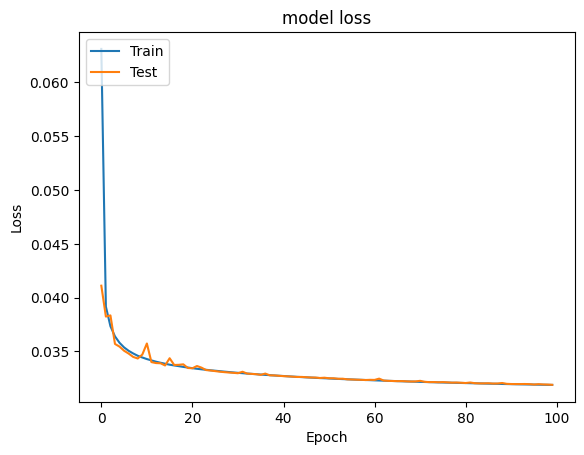

In [18]:
plot_his(history_3)

In [19]:
model_3.evaluate(X_test,Y_test)

6554/6554 [==============================] - 16s 2ms/step - loss: 0.0319 - rmse: 0.0558 - r2: 0.9998 - mae: 0.0319 - mse: 0.0031 - mape: 6468.7456


[0.031900957226753235,
 0.05577339231967926,
 0.9998005628585815,
 0.031900957226753235,
 0.0031106711830943823,
 6468.74560546875]

In [20]:
Y_pred_3 = model_3.predict(X_test)

6554/6554 [==============================] - 7s 1ms/step


In [21]:
model_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                128       
                                                                 
 dense_1 (Dense)             (None, 128)               4224      
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 14,721
Trainable params: 14,721
Non-trainable params: 0
_________________________________________________________________


In [22]:
AIC_value(model_3,Y_pred_3,Y_test)

AIC:  29532.275


In [23]:
model_3.save('Saved_models/model_3_SOEesti.h5')

In [24]:
%%time
tf.random.set_seed(42)

model_4 = tf.keras.Sequential([tf.keras.layers.Dense(50,activation = 'relu'),
                               tf.keras.layers.Dense(50),
                               tf.keras.layers.Dense(50),
                               tf.keras.layers.Dense(100),
                               tf.keras.layers.Dense(50),
                               tf.keras.layers.Dense(20),
                               tf.keras.layers.Dense(1)])

model_4.compile(loss = tf.keras.losses.mae,
                optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001,decay=0.001),
                metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse'),
                         tfa.metrics.RSquare(name='r2'),'mae','mse','mape'])

history_4 = model_4.fit(X_train,Y_train, epochs= 100,batch_size=32,validation_data=(X_test,Y_test), callbacks = callback)

Epoch 1/100
26215/26215 [==============================] - 70s 3ms/step - loss: 0.0722 - rmse: 0.1836 - r2: 0.9978 - mae: 0.0722 - mse: 0.0337 - mape: 90111.9609 - val_loss: 0.0486 - val_rmse: 0.0782 - val_r2: 0.9996 - val_mae: 0.0486 - val_mse: 0.0061 - val_mape: 30550.3027
Epoch 2/100
26215/26215 [==============================] - 67s 3ms/step - loss: 0.0465 - rmse: 0.0761 - r2: 0.9996 - mae: 0.0465 - mse: 0.0058 - mape: 36402.5430 - val_loss: 0.0450 - val_rmse: 0.0750 - val_r2: 0.9996 - val_mae: 0.0450 - val_mse: 0.0056 - val_mape: 29801.4473
Epoch 3/100
26215/26215 [==============================] - 67s 3ms/step - loss: 0.0448 - rmse: 0.0744 - r2: 0.9996 - mae: 0.0448 - mse: 0.0055 - mape: 34600.7578 - val_loss: 0.0440 - val_rmse: 0.0739 - val_r2: 0.9996 - val_mae: 0.0440 - val_mse: 0.0055 - val_mape: 28049.6699
Epoch 4/100
26215/26215 [==============================] - 67s 3ms/step - loss: 0.0440 - rmse: 0.0734 - r2: 0.9997 - mae: 0.0440 - mse: 0.0054 - mape: 33272.6797 - val_loss

Epoch 31/100
26215/26215 [==============================] - 68s 3ms/step - loss: 0.0414 - rmse: 0.0697 - r2: 0.9997 - mae: 0.0414 - mse: 0.0049 - mape: 29576.9160 - val_loss: 0.0416 - val_rmse: 0.0697 - val_r2: 0.9997 - val_mae: 0.0416 - val_mse: 0.0049 - val_mape: 35773.9883
Epoch 32/100
26215/26215 [==============================] - 67s 3ms/step - loss: 0.0413 - rmse: 0.0696 - r2: 0.9997 - mae: 0.0413 - mse: 0.0048 - mape: 29449.0254 - val_loss: 0.0414 - val_rmse: 0.0698 - val_r2: 0.9997 - val_mae: 0.0414 - val_mse: 0.0049 - val_mape: 27293.9102
Epoch 33/100
26215/26215 [==============================] - 67s 3ms/step - loss: 0.0413 - rmse: 0.0696 - r2: 0.9997 - mae: 0.0413 - mse: 0.0048 - mape: 29517.1348 - val_loss: 0.0413 - val_rmse: 0.0697 - val_r2: 0.9997 - val_mae: 0.0413 - val_mse: 0.0049 - val_mape: 31395.7383
Epoch 34/100
26215/26215 [==============================] - 68s 3ms/step - loss: 0.0413 - rmse: 0.0696 - r2: 0.9997 - mae: 0.0413 - mse: 0.0048 - mape: 29348.7676 - val_

Epoch 61/100
26215/26215 [==============================] - 67s 3ms/step - loss: 0.0408 - rmse: 0.0688 - r2: 0.9997 - mae: 0.0408 - mse: 0.0047 - mape: 26102.3516 - val_loss: 0.0409 - val_rmse: 0.0690 - val_r2: 0.9997 - val_mae: 0.0409 - val_mse: 0.0048 - val_mape: 27515.7871
Epoch 62/100
26215/26215 [==============================] - 68s 3ms/step - loss: 0.0408 - rmse: 0.0688 - r2: 0.9997 - mae: 0.0408 - mse: 0.0047 - mape: 26003.0996 - val_loss: 0.0409 - val_rmse: 0.0689 - val_r2: 0.9997 - val_mae: 0.0409 - val_mse: 0.0048 - val_mape: 27493.2520
Epoch 63/100
26215/26215 [==============================] - 68s 3ms/step - loss: 0.0408 - rmse: 0.0688 - r2: 0.9997 - mae: 0.0408 - mse: 0.0047 - mape: 26288.0586 - val_loss: 0.0409 - val_rmse: 0.0690 - val_r2: 0.9997 - val_mae: 0.0409 - val_mse: 0.0048 - val_mape: 23838.4570
Epoch 64/100
26215/26215 [==============================] - 67s 3ms/step - loss: 0.0408 - rmse: 0.0688 - r2: 0.9997 - mae: 0.0408 - mse: 0.0047 - mape: 25834.9062 - val_

Epoch 91/100
26215/26215 [==============================] - 67s 3ms/step - loss: 0.0406 - rmse: 0.0684 - r2: 0.9997 - mae: 0.0406 - mse: 0.0047 - mape: 25703.1211 - val_loss: 0.0407 - val_rmse: 0.0687 - val_r2: 0.9997 - val_mae: 0.0407 - val_mse: 0.0047 - val_mape: 24095.8809
Epoch 92/100
26215/26215 [==============================] - 68s 3ms/step - loss: 0.0405 - rmse: 0.0684 - r2: 0.9997 - mae: 0.0405 - mse: 0.0047 - mape: 25378.4453 - val_loss: 0.0407 - val_rmse: 0.0687 - val_r2: 0.9997 - val_mae: 0.0407 - val_mse: 0.0047 - val_mape: 25656.6016
Epoch 93/100
26215/26215 [==============================] - 68s 3ms/step - loss: 0.0405 - rmse: 0.0684 - r2: 0.9997 - mae: 0.0405 - mse: 0.0047 - mape: 25290.4102 - val_loss: 0.0406 - val_rmse: 0.0686 - val_r2: 0.9997 - val_mae: 0.0406 - val_mse: 0.0047 - val_mape: 25106.4551
Epoch 94/100
26215/26215 [==============================] - 67s 3ms/step - loss: 0.0405 - rmse: 0.0684 - r2: 0.9997 - mae: 0.0405 - mse: 0.0047 - mape: 25208.2285 - val_

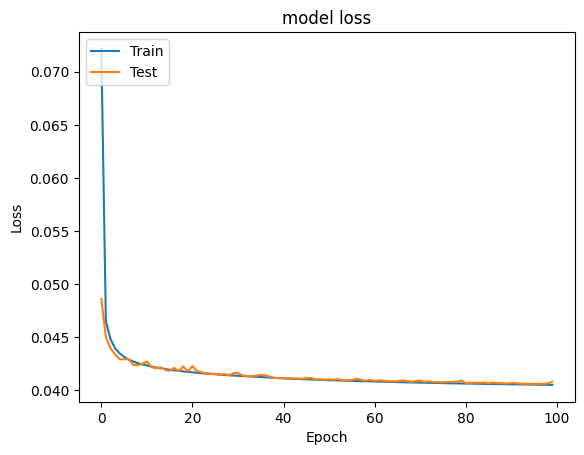

In [25]:
plot_his(history_4)

In [26]:
model_4.evaluate(X_test,Y_test)

6554/6554 [==============================] - 16s 2ms/step - loss: 0.0408 - rmse: 0.0687 - r2: 0.9997 - mae: 0.0408 - mse: 0.0047 - mape: 24638.3203


[0.04080270975828171,
 0.06871840357780457,
 0.9996972680091858,
 0.04080270975828171,
 0.004722218960523605,
 24638.3203125]

In [27]:
Y_pred_4 = model_4.predict(X_test)

6554/6554 [==============================] - 7s 1ms/step


In [28]:
model_4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 50)                200       
                                                                 
 dense_6 (Dense)             (None, 50)                2550      
                                                                 
 dense_7 (Dense)             (None, 50)                2550      
                                                                 
 dense_8 (Dense)             (None, 100)               5100      
                                                                 
 dense_9 (Dense)             (None, 50)                5050      
                                                                 
 dense_10 (Dense)            (None, 20)                1020      
                                                                 
 dense_11 (Dense)            (None, 1)                

In [29]:
AIC_value(model_4,Y_pred_4,Y_test)

AIC:  33072.34


In [30]:
model_4.save('Saved_models/model_4_SOEesti.h5')

# LSTM

In [17]:
%%time
tf.random.set_seed(42)

model_5 = tf.keras.Sequential([tf.keras.layers.LSTM(50,activation= 'linear',return_sequences=True, input_shape=(3,1)),
                               tf.keras.layers.LSTM(10,activation='linear'),
                               tf.keras.layers.Dense(1)])

model_5.compile(loss = tf.keras.losses.mae,
                optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001,decay=0.0001),
                metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse'),
                         tfa.metrics.RSquare(name='r2'),'mae','mse','mape'])

history_5 = model_5.fit(X_train,Y_train,epochs=100,validation_data=(X_test,Y_test),callbacks = callback)

Epoch 1/100
26215/26215 [==============================] - 151s 6ms/step - loss: 0.1766 - rmse: 0.5862 - r2: 0.9779 - mae: 0.1766 - mse: 0.3437 - mape: 278802.8750 - val_loss: 0.0791 - val_rmse: 0.1151 - val_r2: 0.9991 - val_mae: 0.0791 - val_mse: 0.0133 - val_mape: 16637.4102
Epoch 2/100
26215/26215 [==============================] - 152s 6ms/step - loss: 0.0628 - rmse: 0.0994 - r2: 0.9994 - mae: 0.0628 - mse: 0.0099 - mape: 22215.2500 - val_loss: 0.0577 - val_rmse: 0.0939 - val_r2: 0.9994 - val_mae: 0.0577 - val_mse: 0.0088 - val_mape: 21980.1133
Epoch 3/100
26215/26215 [==============================] - 151s 6ms/step - loss: 0.0566 - rmse: 0.0913 - r2: 0.9995 - mae: 0.0566 - mse: 0.0083 - mape: 19794.8379 - val_loss: 0.0524 - val_rmse: 0.0869 - val_r2: 0.9995 - val_mae: 0.0524 - val_mse: 0.0076 - val_mape: 17032.1289
Epoch 4/100
26215/26215 [==============================] - 154s 6ms/step - loss: 0.0530 - rmse: 0.0865 - r2: 0.9995 - mae: 0.0530 - mse: 0.0075 - mape: 19253.2598 - val

Epoch 31/100
26215/26215 [==============================] - 160s 6ms/step - loss: 0.0398 - rmse: 0.0693 - r2: 0.9997 - mae: 0.0398 - mse: 0.0048 - mape: 8027.4604 - val_loss: 0.0403 - val_rmse: 0.0696 - val_r2: 0.9997 - val_mae: 0.0403 - val_mse: 0.0048 - val_mape: 9633.7295
Epoch 32/100
26215/26215 [==============================] - 156s 6ms/step - loss: 0.0397 - rmse: 0.0692 - r2: 0.9997 - mae: 0.0397 - mse: 0.0048 - mape: 8223.4951 - val_loss: 0.0396 - val_rmse: 0.0694 - val_r2: 0.9997 - val_mae: 0.0396 - val_mse: 0.0048 - val_mape: 10621.1455
Epoch 33/100
26215/26215 [==============================] - 156s 6ms/step - loss: 0.0396 - rmse: 0.0691 - r2: 0.9997 - mae: 0.0396 - mse: 0.0048 - mape: 8177.4854 - val_loss: 0.0405 - val_rmse: 0.0700 - val_r2: 0.9997 - val_mae: 0.0405 - val_mse: 0.0049 - val_mape: 10130.0645
Epoch 34/100
26215/26215 [==============================] - 157s 6ms/step - loss: 0.0395 - rmse: 0.0691 - r2: 0.9997 - mae: 0.0395 - mse: 0.0048 - mape: 8160.2695 - val_l

Epoch 61/100
26215/26215 [==============================] - 104s 4ms/step - loss: 0.0370 - rmse: 0.0673 - r2: 0.9997 - mae: 0.0370 - mse: 0.0045 - mape: 7919.6147 - val_loss: 0.0372 - val_rmse: 0.0680 - val_r2: 0.9997 - val_mae: 0.0372 - val_mse: 0.0046 - val_mape: 8806.2305
Epoch 62/100
26215/26215 [==============================] - 100s 4ms/step - loss: 0.0369 - rmse: 0.0672 - r2: 0.9997 - mae: 0.0369 - mse: 0.0045 - mape: 7766.2368 - val_loss: 0.0372 - val_rmse: 0.0675 - val_r2: 0.9997 - val_mae: 0.0372 - val_mse: 0.0046 - val_mape: 5663.6982
Epoch 63/100
26215/26215 [==============================] - 103s 4ms/step - loss: 0.0368 - rmse: 0.0671 - r2: 0.9997 - mae: 0.0368 - mse: 0.0045 - mape: 7731.7739 - val_loss: 0.0371 - val_rmse: 0.0680 - val_r2: 0.9997 - val_mae: 0.0371 - val_mse: 0.0046 - val_mape: 7735.1812
Epoch 64/100
26215/26215 [==============================] - 103s 4ms/step - loss: 0.0367 - rmse: 0.0671 - r2: 0.9997 - mae: 0.0367 - mse: 0.0045 - mape: 7843.5791 - val_los

Epoch 91/100
26215/26215 [==============================] - 145s 6ms/step - loss: 0.0352 - rmse: 0.0658 - r2: 0.9997 - mae: 0.0352 - mse: 0.0043 - mape: 7099.4248 - val_loss: 0.0359 - val_rmse: 0.0662 - val_r2: 0.9997 - val_mae: 0.0359 - val_mse: 0.0044 - val_mape: 5734.6245
Epoch 92/100
26215/26215 [==============================] - 148s 6ms/step - loss: 0.0352 - rmse: 0.0657 - r2: 0.9997 - mae: 0.0352 - mse: 0.0043 - mape: 7013.9404 - val_loss: 0.0353 - val_rmse: 0.0661 - val_r2: 0.9997 - val_mae: 0.0353 - val_mse: 0.0044 - val_mape: 5653.5625
Epoch 93/100
26215/26215 [==============================] - 149s 6ms/step - loss: 0.0351 - rmse: 0.0657 - r2: 0.9997 - mae: 0.0351 - mse: 0.0043 - mape: 6977.1538 - val_loss: 0.0352 - val_rmse: 0.0660 - val_r2: 0.9997 - val_mae: 0.0352 - val_mse: 0.0044 - val_mape: 7692.7563
Epoch 94/100
26215/26215 [==============================] - 147s 6ms/step - loss: 0.0351 - rmse: 0.0656 - r2: 0.9997 - mae: 0.0351 - mse: 0.0043 - mape: 7023.9985 - val_los

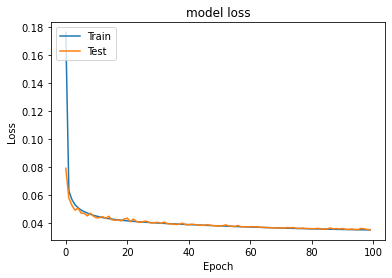

In [18]:
plot_his(history_5)

In [19]:
model_5.evaluate(X_test,Y_test)

6554/6554 [==============================] - 27s 3ms/step - loss: 0.0350 - rmse: 0.0658 - r2: 0.9997 - mae: 0.0350 - mse: 0.0043 - mape: 5405.7021


[0.03498302400112152,
 0.06577415019273758,
 0.9997214674949646,
 0.03498302400112152,
 0.004326239228248596,
 5405.7021484375]

In [20]:
model_5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 50)             10400     
                                                                 
 lstm_1 (LSTM)               (None, 10)                2440      
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 12851 (50.20 KB)
Trainable params: 12851 (50.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
prediction_5 = model_5.predict(X_test)

6554/6554 [==============================] - 25s 3ms/step


In [22]:
AIC_value(model_5,prediction_5,Y_test)

AIC:  25792.693


In [23]:
model_5.save('Saved_models/model_5_SOEesti.h5')

C:\Users\91987\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
tf.random.set_seed(42)

model_6 = tf.keras.Sequential([tf.keras.layers.LSTM(50,activation= 'linear',return_sequences=True, input_shape=(3,1)),
                               tf.keras.layers.LSTM(30,activation= 'linear'),
                               tf.keras.layers.Dense(20,activation='relu'),
                               tf.keras.layers.Dense(1,activation='linear')])

model_6.compile(loss = tf.keras.losses.mae,
                optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001,decay = 0.001),
                metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse'),
                         tfa.metrics.RSquare(name='r2'),'mae','mse','mape'])

history_6 = model_6.fit(X_train,Y_train,epochs=100,validation_data=(X_test,Y_test),callbacks = callback)

Epoch 1/100
26215/26215 [==============================] - 162s 6ms/step - loss: 0.3387 - rmse: 0.8032 - r2: 0.9585 - mae: 0.3387 - mse: 0.6451 - mape: 525568.8750 - val_loss: 0.1524 - val_rmse: 0.2386 - val_r2: 0.9963 - val_mae: 0.1524 - val_mse: 0.0569 - val_mape: 211003.0938
Epoch 2/100
26215/26215 [==============================] - 151s 6ms/step - loss: 0.1250 - rmse: 0.2000 - r2: 0.9974 - mae: 0.1250 - mse: 0.0400 - mape: 177425.7500 - val_loss: 0.1022 - val_rmse: 0.1684 - val_r2: 0.9982 - val_mae: 0.1022 - val_mse: 0.0284 - val_mape: 176616.2656
Epoch 3/100
26215/26215 [==============================] - 150s 6ms/step - loss: 0.0947 - rmse: 0.1577 - r2: 0.9984 - mae: 0.0947 - mse: 0.0249 - mape: 148057.3125 - val_loss: 0.0912 - val_rmse: 0.1497 - val_r2: 0.9986 - val_mae: 0.0912 - val_mse: 0.0224 - val_mape: 157269.2344
Epoch 4/100
26215/26215 [==============================] - 147s 6ms/step - loss: 0.0843 - rmse: 0.1451 - r2: 0.9986 - mae: 0.0843 - mse: 0.0211 - mape: 125039.0547

26215/26215 [==============================] - 141s 5ms/step - loss: 0.0602 - rmse: 0.1134 - r2: 0.9992 - mae: 0.0602 - mse: 0.0129 - mape: 97132.1875 - val_loss: 0.0600 - val_rmse: 0.1129 - val_r2: 0.9992 - val_mae: 0.0600 - val_mse: 0.0127 - val_mape: 101977.9609
Epoch 31/100
26215/26215 [==============================] - 156s 6ms/step - loss: 0.0600 - rmse: 0.1131 - r2: 0.9992 - mae: 0.0600 - mse: 0.0128 - mape: 96795.9922 - val_loss: 0.0598 - val_rmse: 0.1128 - val_r2: 0.9992 - val_mae: 0.0598 - val_mse: 0.0127 - val_mape: 100572.7266
Epoch 32/100
26215/26215 [==============================] - 144s 5ms/step - loss: 0.0599 - rmse: 0.1128 - r2: 0.9992 - mae: 0.0599 - mse: 0.0127 - mape: 96781.6094 - val_loss: 0.0598 - val_rmse: 0.1124 - val_r2: 0.9992 - val_mae: 0.0598 - val_mse: 0.0126 - val_mape: 100237.4453
Epoch 33/100
26215/26215 [==============================] - 135s 5ms/step - loss: 0.0598 - rmse: 0.1126 - r2: 0.9992 - mae: 0.0598 - mse: 0.0127 - mape: 96593.0859 - val_loss: 

26215/26215 [==============================] - 146s 6ms/step - loss: 0.0580 - rmse: 0.1083 - r2: 0.9992 - mae: 0.0580 - mse: 0.0117 - mape: 92985.2969 - val_loss: 0.0580 - val_rmse: 0.1080 - val_r2: 0.9992 - val_mae: 0.0580 - val_mse: 0.0117 - val_mape: 96505.2188
Epoch 60/100
26215/26215 [==============================] - 150s 6ms/step - loss: 0.0579 - rmse: 0.1082 - r2: 0.9992 - mae: 0.0579 - mse: 0.0117 - mape: 92978.0781 - val_loss: 0.0578 - val_rmse: 0.1079 - val_r2: 0.9993 - val_mae: 0.0578 - val_mse: 0.0116 - val_mape: 96751.7109
Epoch 61/100
26215/26215 [==============================] - 157s 6ms/step - loss: 0.0579 - rmse: 0.1081 - r2: 0.9992 - mae: 0.0579 - mse: 0.0117 - mape: 92787.8047 - val_loss: 0.0579 - val_rmse: 0.1078 - val_r2: 0.9993 - val_mae: 0.0579 - val_mse: 0.0116 - val_mape: 96463.9375
Epoch 62/100
26215/26215 [==============================] - 152s 6ms/step - loss: 0.0578 - rmse: 0.1080 - r2: 0.9993 - mae: 0.0578 - mse: 0.0117 - mape: 92683.0469 - val_loss: 0.0

26215/26215 [==============================] - 167s 6ms/step - loss: 0.0569 - rmse: 0.1058 - r2: 0.9993 - mae: 0.0569 - mse: 0.0112 - mape: 90905.5859 - val_loss: 0.0568 - val_rmse: 0.1055 - val_r2: 0.9993 - val_mae: 0.0568 - val_mse: 0.0111 - val_mape: 94515.5312
Epoch 89/100
26215/26215 [==============================] - 150s 6ms/step - loss: 0.0568 - rmse: 0.1057 - r2: 0.9993 - mae: 0.0568 - mse: 0.0112 - mape: 90904.6875 - val_loss: 0.0570 - val_rmse: 0.1055 - val_r2: 0.9993 - val_mae: 0.0570 - val_mse: 0.0111 - val_mape: 96776.8516
Epoch 90/100
26215/26215 [==============================] - 141s 5ms/step - loss: 0.0568 - rmse: 0.1056 - r2: 0.9993 - mae: 0.0568 - mse: 0.0112 - mape: 90791.7109 - val_loss: 0.0568 - val_rmse: 0.1052 - val_r2: 0.9993 - val_mae: 0.0568 - val_mse: 0.0111 - val_mape: 94868.9297
Epoch 91/100
26215/26215 [==============================] - 132s 5ms/step - loss: 0.0568 - rmse: 0.1055 - r2: 0.9993 - mae: 0.0568 - mse: 0.0111 - mape: 90699.0938 - val_loss: 0.0

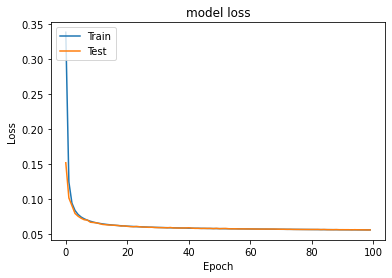

In [25]:
plot_his(history_6)

In [26]:
model_6.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 3, 50)             10400     
                                                                 
 lstm_3 (LSTM)               (None, 30)                9720      
                                                                 
 dense_1 (Dense)             (None, 20)                620       
                                                                 
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
Total params: 20761 (81.10 KB)
Trainable params: 20761 (81.10 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
model_6.evaluate(X_test,Y_test)

6554/6554 [==============================] - 29s 3ms/step - loss: 0.0566 - rmse: 0.1047 - r2: 0.9993 - mae: 0.0566 - mse: 0.0110 - mape: 94259.8438


[0.05656738579273224,
 0.1047186404466629,
 0.9992939233779907,
 0.05656738579273224,
 0.010965993627905846,
 94259.84375]

In [28]:
prediction_6 = model_6.predict(X_test)

6554/6554 [==============================] - 19s 2ms/step


In [29]:
AIC_value(model_6,prediction_6,Y_test)

AIC:  41612.652


In [30]:
model_6.save('Saved_models/model_6_SOEesti.h5')

C:\Users\91987\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [31]:
tf.random.set_seed(42)

model_7 = tf.keras.Sequential([tf.keras.layers.LSTM(20,activation= 'relu',return_sequences=True, input_shape=(3,1)),
                               tf.keras.layers.LSTM(10,activation='linear'),
                               tf.keras.layers.Dense(10),
                               tf.keras.layers.Dense(1)])

model_7.compile(loss = tf.keras.losses.mae,
                optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001,decay=0.01),
                metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse'),
                         tfa.metrics.RSquare(name='r2'),'mae','mse','mape'])

history_7 = model_7.fit(X_train,Y_train,batch_size = 32,epochs=100,validation_data=(X_test,Y_test),callbacks = callback)

Epoch 1/100
26215/26215 [==============================] - 150s 5ms/step - loss: 2.9864 - rmse: 3.4881 - r2: 0.2180 - mae: 2.9864 - mse: 12.1669 - mape: 8084409.5000 - val_loss: 2.9573 - val_rmse: 3.4492 - val_r2: 0.2340 - val_mae: 2.9573 - val_mse: 11.8970 - val_mape: 8078709.0000
Epoch 2/100
26215/26215 [==============================] - 125s 5ms/step - loss: 2.9469 - rmse: 3.4374 - r2: 0.2406 - mae: 2.9469 - mse: 11.8154 - mape: 7764887.5000 - val_loss: 2.9415 - val_rmse: 3.4279 - val_r2: 0.2434 - val_mae: 2.9415 - val_mse: 11.7505 - val_mape: 7936855.0000
Epoch 3/100
26215/26215 [==============================] - 131s 5ms/step - loss: 2.9343 - rmse: 3.4231 - r2: 0.2469 - mae: 2.9343 - mse: 11.7175 - mape: 7680875.5000 - val_loss: 2.9313 - val_rmse: 3.4186 - val_r2: 0.2475 - val_mae: 2.9313 - val_mse: 11.6868 - val_mape: 7898194.0000
Epoch 4/100
26215/26215 [==============================] - 132s 5ms/step - loss: 2.9252 - rmse: 3.4127 - r2: 0.2515 - mae: 2.9252 - mse: 11.6468 - mape

Epoch 30/100
26215/26215 [==============================] - 133s 5ms/step - loss: 2.8335 - rmse: 3.3073 - r2: 0.2970 - mae: 2.8335 - mse: 10.9385 - mape: 7474887.5000 - val_loss: 2.8346 - val_rmse: 3.3063 - val_r2: 0.2962 - val_mae: 2.8346 - val_mse: 10.9315 - val_mape: 7702844.0000
Epoch 31/100
26215/26215 [==============================] - 133s 5ms/step - loss: 2.8312 - rmse: 3.3043 - r2: 0.2983 - mae: 2.8312 - mse: 10.9185 - mape: 7470641.5000 - val_loss: 2.8324 - val_rmse: 3.3042 - val_r2: 0.2970 - val_mae: 2.8324 - val_mse: 10.9178 - val_mape: 7705233.5000
Epoch 32/100
26215/26215 [==============================] - 130s 5ms/step - loss: 2.8290 - rmse: 3.3021 - r2: 0.2992 - mae: 2.8290 - mse: 10.9039 - mape: 7471866.5000 - val_loss: 2.8302 - val_rmse: 3.3015 - val_r2: 0.2982 - val_mae: 2.8302 - val_mse: 10.8998 - val_mape: 7702734.0000
Epoch 33/100
26215/26215 [==============================] - 124s 5ms/step - loss: 2.8268 - rmse: 3.2996 - r2: 0.3003 - mae: 2.8268 - mse: 10.8873 - 

Epoch 59/100
26215/26215 [==============================] - 145s 6ms/step - loss: 2.7771 - rmse: 3.2409 - r2: 0.3250 - mae: 2.7771 - mse: 10.5032 - mape: 7455690.0000 - val_loss: 2.7785 - val_rmse: 3.2406 - val_r2: 0.3239 - val_mae: 2.7785 - val_mse: 10.5013 - val_mape: 7686195.0000
Epoch 60/100
26215/26215 [==============================] - 149s 6ms/step - loss: 2.7753 - rmse: 3.2388 - r2: 0.3258 - mae: 2.7753 - mse: 10.4898 - mape: 7456161.5000 - val_loss: 2.7767 - val_rmse: 3.2384 - val_r2: 0.3248 - val_mae: 2.7767 - val_mse: 10.4870 - val_mape: 7685595.0000
Epoch 61/100
26215/26215 [==============================] - 150s 6ms/step - loss: 2.7735 - rmse: 3.2363 - r2: 0.3269 - mae: 2.7735 - mse: 10.4737 - mape: 7453732.5000 - val_loss: 2.7749 - val_rmse: 3.2363 - val_r2: 0.3256 - val_mae: 2.7749 - val_mse: 10.4736 - val_mape: 7686088.5000
Epoch 62/100
26215/26215 [==============================] - 146s 6ms/step - loss: 2.7717 - rmse: 3.2344 - r2: 0.3277 - mae: 2.7717 - mse: 10.4612 - 

Epoch 88/100
26215/26215 [==============================] - 152s 6ms/step - loss: 2.7248 - rmse: 3.1795 - r2: 0.3503 - mae: 2.7248 - mse: 10.1093 - mape: 7454080.5000 - val_loss: 2.7264 - val_rmse: 3.1793 - val_r2: 0.3492 - val_mae: 2.7264 - val_mse: 10.1080 - val_mape: 7683179.0000
Epoch 89/100
26215/26215 [==============================] - 146s 6ms/step - loss: 2.7232 - rmse: 3.1775 - r2: 0.3511 - mae: 2.7232 - mse: 10.0964 - mape: 7453178.0000 - val_loss: 2.7247 - val_rmse: 3.1774 - val_r2: 0.3500 - val_mae: 2.7247 - val_mse: 10.0960 - val_mape: 7683339.0000
Epoch 90/100
26215/26215 [==============================] - 151s 6ms/step - loss: 2.7216 - rmse: 3.1755 - r2: 0.3519 - mae: 2.7216 - mse: 10.0838 - mape: 7452533.0000 - val_loss: 2.7231 - val_rmse: 3.1756 - val_r2: 0.3507 - val_mae: 2.7231 - val_mse: 10.0845 - val_mape: 7683780.5000
Epoch 91/100
26215/26215 [==============================] - 154s 6ms/step - loss: 2.7200 - rmse: 3.1738 - r2: 0.3526 - mae: 2.7200 - mse: 10.0732 - 

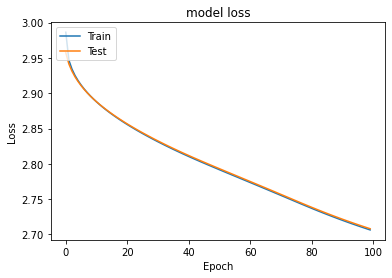

In [32]:
plot_his(history_7)

In [33]:
prediction_7 = model_7.predict(X_test)

6554/6554 [==============================] - 25s 3ms/step


In [34]:
model_7.evaluate(X_test,Y_test)

6554/6554 [==============================] - 26s 3ms/step - loss: 2.7080 - rmse: 3.1583 - r2: 0.3577 - mae: 2.7080 - mse: 9.9750 - mape: 7686620.5000


[2.708031415939331,
 3.158327341079712,
 0.3577430248260498,
 2.708031415939331,
 9.975031852722168,
 7686620.5]

In [35]:
AIC_value(model_7,prediction_7,Y_test)

AIC:  6318.133


In [36]:
model_7.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 3, 20)             1760      
                                                                 
 lstm_5 (LSTM)               (None, 10)                1240      
                                                                 
 dense_3 (Dense)             (None, 10)                110       
                                                                 
 dense_4 (Dense)             (None, 1)                 11        
                                                                 
Total params: 3121 (12.19 KB)
Trainable params: 3121 (12.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [37]:
model_7.save('Saved_models/model_7_SOEesti.h5')

C:\Users\91987\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [38]:
%%time
tf.random.set_seed(42)

model_8 = tf.keras.Sequential([tf.keras.layers.LSTM(30,activation= 'linear',return_sequences=True, input_shape=(3,1)),
                               tf.keras.layers.LSTM(20,activation= 'linear'),
                               tf.keras.layers.Dense(10,activation='linear'),
                               tf.keras.layers.Dense(1,activation='linear')])

model_8.compile(loss = tf.keras.losses.mae,
                optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001,decay = 0.001),
                metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse'),
                         tfa.metrics.RSquare(name='r2'),'mae','mse','mape'])

history_8 = model_8.fit(X_train,Y_train,batch_size=32,epochs=100,validation_data=(X_test,Y_test))

Epoch 1/100
26215/26215 [==============================] - 188s 7ms/step - loss: 0.4020 - rmse: 0.8379 - r2: 0.9549 - mae: 0.4020 - mse: 0.7020 - mape: 566040.1875 - val_loss: 0.2472 - val_rmse: 0.3791 - val_r2: 0.9907 - val_mae: 0.2472 - val_mse: 0.1437 - val_mape: 211516.0625
Epoch 2/100
26215/26215 [==============================] - 196s 7ms/step - loss: 0.2285 - rmse: 0.3611 - r2: 0.9916 - mae: 0.2285 - mse: 0.1304 - mape: 213511.4688 - val_loss: 0.2162 - val_rmse: 0.3508 - val_r2: 0.9921 - val_mae: 0.2162 - val_mse: 0.1231 - val_mape: 208657.1094
Epoch 3/100
26215/26215 [==============================] - 191s 7ms/step - loss: 0.2073 - rmse: 0.3444 - r2: 0.9924 - mae: 0.2073 - mse: 0.1186 - mape: 204177.4531 - val_loss: 0.2010 - val_rmse: 0.3386 - val_r2: 0.9926 - val_mae: 0.2010 - val_mse: 0.1147 - val_mape: 220578.2188
Epoch 4/100
26215/26215 [==============================] - 188s 7ms/step - loss: 0.1964 - rmse: 0.3311 - r2: 0.9930 - mae: 0.1964 - mse: 0.1096 - mape: 209692.2344

26215/26215 [==============================] - 124s 5ms/step - loss: 0.1124 - rmse: 0.1919 - r2: 0.9976 - mae: 0.1124 - mse: 0.0368 - mape: 181725.9531 - val_loss: 0.1121 - val_rmse: 0.1908 - val_r2: 0.9977 - val_mae: 0.1121 - val_mse: 0.0364 - val_mape: 188472.3906
Epoch 31/100
26215/26215 [==============================] - 123s 5ms/step - loss: 0.1113 - rmse: 0.1899 - r2: 0.9977 - mae: 0.1113 - mse: 0.0361 - mape: 182652.4844 - val_loss: 0.1111 - val_rmse: 0.1892 - val_r2: 0.9977 - val_mae: 0.1111 - val_mse: 0.0358 - val_mape: 192132.7188
Epoch 32/100
26215/26215 [==============================] - 129s 5ms/step - loss: 0.1102 - rmse: 0.1881 - r2: 0.9977 - mae: 0.1102 - mse: 0.0354 - mape: 182442.5625 - val_loss: 0.1100 - val_rmse: 0.1871 - val_r2: 0.9977 - val_mae: 0.1100 - val_mse: 0.0350 - val_mape: 194320.0625
Epoch 33/100
26215/26215 [==============================] - 125s 5ms/step - loss: 0.1092 - rmse: 0.1864 - r2: 0.9978 - mae: 0.1092 - mse: 0.0347 - mape: 183644.0469 - val_lo

26215/26215 [==============================] - 157s 6ms/step - loss: 0.0925 - rmse: 0.1590 - r2: 0.9984 - mae: 0.0925 - mse: 0.0253 - mape: 171596.9844 - val_loss: 0.0926 - val_rmse: 0.1587 - val_r2: 0.9984 - val_mae: 0.0926 - val_mse: 0.0252 - val_mape: 175661.2031
Epoch 60/100
26215/26215 [==============================] - 141s 5ms/step - loss: 0.0921 - rmse: 0.1584 - r2: 0.9984 - mae: 0.0921 - mse: 0.0251 - mape: 170961.0938 - val_loss: 0.0921 - val_rmse: 0.1580 - val_r2: 0.9984 - val_mae: 0.0921 - val_mse: 0.0250 - val_mape: 179577.0781
Epoch 61/100
26215/26215 [==============================] - 142s 5ms/step - loss: 0.0918 - rmse: 0.1579 - r2: 0.9984 - mae: 0.0918 - mse: 0.0249 - mape: 170362.0625 - val_loss: 0.0917 - val_rmse: 0.1576 - val_r2: 0.9984 - val_mae: 0.0917 - val_mse: 0.0248 - val_mape: 177727.5469
Epoch 62/100
26215/26215 [==============================] - 167s 6ms/step - loss: 0.0914 - rmse: 0.1573 - r2: 0.9984 - mae: 0.0914 - mse: 0.0247 - mape: 169833.0156 - val_lo

26215/26215 [==============================] - 124s 5ms/step - loss: 0.0849 - rmse: 0.1469 - r2: 0.9986 - mae: 0.0849 - mse: 0.0216 - mape: 163875.8438 - val_loss: 0.0850 - val_rmse: 0.1466 - val_r2: 0.9986 - val_mae: 0.0850 - val_mse: 0.0215 - val_mape: 168997.0156
Epoch 89/100
26215/26215 [==============================] - 123s 5ms/step - loss: 0.0847 - rmse: 0.1466 - r2: 0.9986 - mae: 0.0847 - mse: 0.0215 - mape: 163481.2969 - val_loss: 0.0848 - val_rmse: 0.1464 - val_r2: 0.9986 - val_mae: 0.0848 - val_mse: 0.0214 - val_mape: 170306.9844
Epoch 90/100
26215/26215 [==============================] - 139s 5ms/step - loss: 0.0845 - rmse: 0.1463 - r2: 0.9986 - mae: 0.0845 - mse: 0.0214 - mape: 163493.7500 - val_loss: 0.0846 - val_rmse: 0.1461 - val_r2: 0.9986 - val_mae: 0.0846 - val_mse: 0.0214 - val_mape: 168876.8594
Epoch 91/100
26215/26215 [==============================] - 125s 5ms/step - loss: 0.0843 - rmse: 0.1460 - r2: 0.9986 - mae: 0.0843 - mse: 0.0213 - mape: 163221.7812 - val_lo

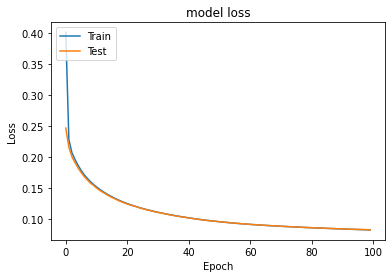

In [39]:
plot_his(history_8)

In [40]:
prediction_8 = model_8.predict(X_test)

6554/6554 [==============================] - 23s 3ms/step


In [41]:
model_8.evaluate(X_test,Y_test)

6554/6554 [==============================] - 27s 3ms/step - loss: 0.0829 - rmse: 0.1435 - r2: 0.9987 - mae: 0.0829 - mse: 0.0206 - mape: 166248.6562


[0.08292726427316666,
 0.14352339506149292,
 0.998673677444458,
 0.08292726427316666,
 0.020598962903022766,
 166248.65625]

In [42]:
AIC_value(model_8,prediction_8, Y_test)

AIC:  16372.6875


In [43]:
model_8.save('Saved_models/model_8_SOEesti.h5')

C:\Users\91987\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# CNN

In [44]:
%%time
model_9 = tf.keras.Sequential([tf.keras.layers.Conv1D(10,2,activation='linear',input_shape=(3,1)),
                               tf.keras.layers.Conv1D(10,2,activation='relu'),
                               tf.keras.layers.Flatten(),
                               tf.keras.layers.Dense(1)])

model_9.compile(loss = tf.keras.losses.mae,
                optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001,decay=0.0001),
                metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse'),
                         tfa.metrics.RSquare(name='r2'),'mae','mse','mape'])

history_9 = model_9.fit(X_train,Y_train,epochs=100,validation_data=(X_test,Y_test),callbacks=callback)

Epoch 1/100
26215/26215 [==============================] - 74s 3ms/step - loss: 0.2436 - rmse: 0.6707 - r2: 0.9711 - mae: 0.2436 - mse: 0.4499 - mape: 311435.9688 - val_loss: 0.0899 - val_rmse: 0.1431 - val_r2: 0.9987 - val_mae: 0.0899 - val_mse: 0.0205 - val_mape: 84731.3672
Epoch 2/100
26215/26215 [==============================] - 64s 2ms/step - loss: 0.0899 - rmse: 0.1429 - r2: 0.9987 - mae: 0.0899 - mse: 0.0204 - mape: 84066.2031 - val_loss: 0.0882 - val_rmse: 0.1416 - val_r2: 0.9987 - val_mae: 0.0882 - val_mse: 0.0200 - val_mape: 68743.1094
Epoch 3/100
26215/26215 [==============================] - 74s 3ms/step - loss: 0.0887 - rmse: 0.1419 - r2: 0.9987 - mae: 0.0887 - mse: 0.0201 - mape: 74230.1328 - val_loss: 0.0877 - val_rmse: 0.1413 - val_r2: 0.9987 - val_mae: 0.0877 - val_mse: 0.0200 - val_mape: 82296.9922
Epoch 4/100
26215/26215 [==============================] - 77s 3ms/step - loss: 0.0882 - rmse: 0.1417 - r2: 0.9987 - mae: 0.0882 - mse: 0.0201 - mape: 70642.9297 - val_los

Epoch 31/100
26215/26215 [==============================] - 59s 2ms/step - loss: 0.0867 - rmse: 0.1439 - r2: 0.9987 - mae: 0.0867 - mse: 0.0207 - mape: 59690.2266 - val_loss: 0.0866 - val_rmse: 0.1434 - val_r2: 0.9987 - val_mae: 0.0866 - val_mse: 0.0206 - val_mape: 61402.7188
Epoch 32/100
26215/26215 [==============================] - 58s 2ms/step - loss: 0.0867 - rmse: 0.1439 - r2: 0.9987 - mae: 0.0867 - mse: 0.0207 - mape: 59704.6289 - val_loss: 0.0865 - val_rmse: 0.1436 - val_r2: 0.9987 - val_mae: 0.0865 - val_mse: 0.0206 - val_mape: 60489.3945
Epoch 33/100
26215/26215 [==============================] - 60s 2ms/step - loss: 0.0867 - rmse: 0.1439 - r2: 0.9987 - mae: 0.0867 - mse: 0.0207 - mape: 59285.7734 - val_loss: 0.0865 - val_rmse: 0.1437 - val_r2: 0.9987 - val_mae: 0.0865 - val_mse: 0.0207 - val_mape: 63254.0352
Epoch 34/100
26215/26215 [==============================] - 59s 2ms/step - loss: 0.0867 - rmse: 0.1439 - r2: 0.9987 - mae: 0.0867 - mse: 0.0207 - mape: 59296.6211 - val_

Epoch 61/100
26215/26215 [==============================] - 58s 2ms/step - loss: 0.0865 - rmse: 0.1441 - r2: 0.9987 - mae: 0.0865 - mse: 0.0208 - mape: 58226.2812 - val_loss: 0.0864 - val_rmse: 0.1440 - val_r2: 0.9987 - val_mae: 0.0864 - val_mse: 0.0207 - val_mape: 60293.9102
Epoch 62/100
26215/26215 [==============================] - 60s 2ms/step - loss: 0.0865 - rmse: 0.1441 - r2: 0.9987 - mae: 0.0865 - mse: 0.0208 - mape: 58420.8359 - val_loss: 0.0864 - val_rmse: 0.1439 - val_r2: 0.9987 - val_mae: 0.0864 - val_mse: 0.0207 - val_mape: 62794.7227
Epoch 63/100
26215/26215 [==============================] - 59s 2ms/step - loss: 0.0865 - rmse: 0.1441 - r2: 0.9987 - mae: 0.0865 - mse: 0.0208 - mape: 58381.2734 - val_loss: 0.0864 - val_rmse: 0.1440 - val_r2: 0.9987 - val_mae: 0.0864 - val_mse: 0.0207 - val_mape: 60412.4922
Epoch 64/100
26215/26215 [==============================] - 70s 3ms/step - loss: 0.0865 - rmse: 0.1441 - r2: 0.9987 - mae: 0.0865 - mse: 0.0208 - mape: 58571.3594 - val_

ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/sequential_4/conv1d_1/Conv1D/Conv2DBackpropFilter' defined at (most recent call last):
    File "C:\Users\91987\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\91987\anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\91987\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\91987\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\91987\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\91987\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\91987\anaconda3\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\91987\anaconda3\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\91987\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\91987\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "C:\Users\91987\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "C:\Users\91987\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 367, in dispatch_shell
      await result
    File "C:\Users\91987\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "C:\Users\91987\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\91987\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\91987\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2863, in run_cell
      result = self._run_cell(
    File "C:\Users\91987\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2909, in _run_cell
      return runner(coro)
    File "C:\Users\91987\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\91987\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3106, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\91987\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3309, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\91987\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3369, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\91987\AppData\Local\Temp\ipykernel_16904\213894057.py", line 1, in <cell line: 1>
      get_ipython().run_cell_magic('time', '', "model_9 = tf.keras.Sequential([tf.keras.layers.Conv1D(10,2,activation='linear',input_shape=(3,1)),\n                               tf.keras.layers.Conv1D(10,2,activation='relu'),\n                               tf.keras.layers.Flatten(),\n                               tf.keras.layers.Dense(1)])\n\nmodel_9.compile(loss = tf.keras.losses.mae,\n                optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001,decay=0.0001),\n                metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse'),\n                         tfa.metrics.RSquare(name='r2'),'mae','mse','mape'])\n\nhistory_9 = model_9.fit(X_train,Y_train,epochs=100,validation_data=(X_test,Y_test),callbacks=callback)\n")
    File "C:\Users\91987\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2347, in run_cell_magic
      result = fn(*args, **kwargs)
    File "C:\Users\91987\anaconda3\lib\site-packages\IPython\core\magics\execution.py", line 1316, in time
      exec(code, glob, local_ns)
    File "<timed exec>", line 11, in <module>
    File "C:\Users\91987\anaconda3\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\91987\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\91987\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "C:\Users\91987\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\91987\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "C:\Users\91987\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1084, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "C:\Users\91987\anaconda3\lib\site-packages\keras\src\optimizers\legacy\optimizer_v2.py", line 598, in minimize
      grads_and_vars = self._compute_gradients(
    File "C:\Users\91987\anaconda3\lib\site-packages\keras\src\optimizers\legacy\optimizer_v2.py", line 656, in _compute_gradients
      grads_and_vars = self._get_gradients(
    File "C:\Users\91987\anaconda3\lib\site-packages\keras\src\optimizers\legacy\optimizer_v2.py", line 532, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/sequential_4/conv1d_1/Conv1D/Conv2DBackpropFilter'
OOM when allocating tensor with shape[34193,1,20] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node gradient_tape/sequential_4/conv1d_1/Conv1D/Conv2DBackpropFilter}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_105345114]

In [45]:
plot_his(history_9)

NameError: name 'history_9' is not defined

In [46]:
model_9.evaluate(X_test,Y_test)

6554/6554 [==============================] - 15s 2ms/step - loss: 0.0864 - rmse: 0.1438 - r2: 0.9987 - mae: 0.0864 - mse: 0.0207 - mape: 60433.2773


[0.08640669286251068,
 0.1438111513853073,
 0.998668372631073,
 0.08640669286251068,
 0.02068164572119713,
 60433.27734375]

In [47]:
prediction_9 = model_9.predict(X_test)

6554/6554 [==============================] - 14s 1ms/step


In [48]:
AIC_value(model_9,prediction_9,Y_test)

AIC:  592.56055


In [49]:
model_9.save('Saved_models/model_9_SOEesti.h5')

C:\Users\91987\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [50]:
%%time
model_10 = tf.keras.Sequential([tf.keras.layers.Conv1D(10,2,activation='linear',input_shape=(3,1)),
                               tf.keras.layers.Conv1D(10,2,activation='linear'),
                               tf.keras.layers.Flatten(),
                               tf.keras.layers.Dense(20),
                               tf.keras.layers.Dense(10),
                               tf.keras.layers.Dense(1,activation='linear')])

model_10.compile(loss = tf.keras.losses.mae,
                optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001,decay=0.0001),
                metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse'),'mae','mse','mape'])

history_10 = model_10.fit(X_train,Y_train,epochs=100,validation_data=(X_test,Y_test),callbacks = callback)

Epoch 1/100
 5664/26215 [=====>........................] - ETA: 50s - loss: 0.4519 - rmse: 0.8869 - mae: 0.4519 - mse: 0.7866 - mape: 996159.5625

ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/sequential_5/conv1d_3/Conv1D/Conv2DBackpropInput' defined at (most recent call last):
    File "C:\Users\91987\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\91987\anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\91987\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\91987\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\91987\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\91987\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\91987\anaconda3\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\91987\anaconda3\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\91987\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\91987\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "C:\Users\91987\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "C:\Users\91987\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 367, in dispatch_shell
      await result
    File "C:\Users\91987\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "C:\Users\91987\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\91987\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\91987\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2863, in run_cell
      result = self._run_cell(
    File "C:\Users\91987\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2909, in _run_cell
      return runner(coro)
    File "C:\Users\91987\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\91987\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3106, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\91987\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3309, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\91987\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3369, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\91987\AppData\Local\Temp\ipykernel_16904\3178581190.py", line 1, in <cell line: 1>
      get_ipython().run_cell_magic('time', '', "model_10 = tf.keras.Sequential([tf.keras.layers.Conv1D(10,2,activation='linear',input_shape=(3,1)),\n                               tf.keras.layers.Conv1D(10,2,activation='linear'),\n                               tf.keras.layers.Flatten(),\n                               tf.keras.layers.Dense(20),\n                               tf.keras.layers.Dense(10),\n                               tf.keras.layers.Dense(1,activation='linear')])\n\nmodel_10.compile(loss = tf.keras.losses.mae,\n                optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001,decay=0.0001),\n                metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse'),'mae','mse','mape'])\n\nhistory_10 = model_10.fit(X_train,Y_train,epochs=100,validation_data=(X_test,Y_test),callbacks = callback)\n")
    File "C:\Users\91987\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2347, in run_cell_magic
      result = fn(*args, **kwargs)
    File "C:\Users\91987\anaconda3\lib\site-packages\IPython\core\magics\execution.py", line 1316, in time
      exec(code, glob, local_ns)
    File "<timed exec>", line 12, in <module>
    File "C:\Users\91987\anaconda3\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\91987\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\91987\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "C:\Users\91987\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\91987\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "C:\Users\91987\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1084, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "C:\Users\91987\anaconda3\lib\site-packages\keras\src\optimizers\legacy\optimizer_v2.py", line 598, in minimize
      grads_and_vars = self._compute_gradients(
    File "C:\Users\91987\anaconda3\lib\site-packages\keras\src\optimizers\legacy\optimizer_v2.py", line 656, in _compute_gradients
      grads_and_vars = self._get_gradients(
    File "C:\Users\91987\anaconda3\lib\site-packages\keras\src\optimizers\legacy\optimizer_v2.py", line 532, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/sequential_5/conv1d_3/Conv1D/Conv2DBackpropInput'
OOM when allocating tensor with shape[34193,1,20] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node gradient_tape/sequential_5/conv1d_3/Conv1D/Conv2DBackpropInput}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_123635809]

In [51]:
plot_his(history_10)

NameError: name 'history_10' is not defined

In [ ]:
model_10.evaluate(X_test,Y_test)

In [ ]:
prediction_10 = model_10.predict(X_test)

In [ ]:
AIC_value(model_10,prediction_10,Y_test)

In [ ]:
model_10.save('Saved_models/model_10_SOEesti.h5')

In [ ]:
%%time
model_11 = tf.keras.Sequential([tf.keras.layers.Conv1D(32,2,activation='linear',input_shape=(3,1)),
                               tf.keras.layers.Conv1D(32,2,activation='linear'),
                               tf.keras.layers.Flatten(),
                               tf.keras.layers.Dense(32,activation="linear"),
                               tf.keras.layers.Dense(16,activation="relu"),
                               tf.keras.layers.Dense(1,activation ='linear')])

model_11.compile(loss = tf.keras.losses.mae,
                optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001,decay=0.001),
                metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse'),'mae','mse','mape'])

history_11 = model_11.fit(X_train,Y_train,epochs=100,validation_data=(X_test,Y_test),callbacks = callback)

In [ ]:
plot_his(history_11)

In [ ]:
model_11.evaluate(X_test,Y_test)

In [ ]:
prediction_11 = model_11.predict(X_test)

In [ ]:
AIC_value(model_11,prediction_11,Y_test)

In [ ]:
model_11.save('Saved_models/model_11_SOEesti.h5')

In [ ]:
%%time
model_12 = tf.keras.Sequential([tf.keras.layers.Conv1D(32,2,activation='linear',input_shape=(3,1)),
                               tf.keras.layers.Conv1D(8,2,activation='linear'),
                               tf.keras.layers.Flatten(),
                               tf.keras.layers.Dense(5),
                               tf.keras.layers.Dense(1,activation = 'linear')])

model_12.compile(loss = tf.keras.losses.mae,
                optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001,decay=0.0001),
                metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse'),'mae','mse','mape'])

history_12 = model_12.fit(X_train,Y_train,epochs=100,validation_data=(X_test,Y_test),callbacks = callback)

In [ ]:
plot_his(history_12)

In [ ]:
model_12.evaluate(X_test,Y_test)

In [ ]:
prediction_12 = model_12.predict(X_test)

In [ ]:
AIC_value(model_11,prediction_11,Y_test)

In [ ]:
model_12.save('Saved_models/model_12_SOEesti.h5')